# Problem Statement: Term Deposit Marketing

We are given the data coming from direct marketing efforts of a European banking institution (Client). The client is interested in developing a robust machine learning system that leverages information coming from the call center data. The marketing campaign involves making a phone call to a client's customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

Ultimately, the client is looking for ways to improve the success rate for calls made to customers for any product that their clients offer. Towards this goal, the client is working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for their customers to make informed decisions.

## Data Description
The data is provided by the client and is a mix of categorical and numeric variables.

### Predictor Variables
1. age : age of customer (numeric)
2. job : type of job (categorical)
3. marital : marital status (categorical)
4. education (categorical)
5. default: has credit in default? (binary)
6. balance: average yearly balance, in euros (numeric)
7. housing: has a housing loan? (binary)
8. loan: has personal loan? (binary)
9. contact: contact communication type (categorical)
10. day: last contact day of the month (numeric)
11. month: last contact month of year (categorical)
12. duration: last contact duration, in seconds (numeric)
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

### Response variable
- y: indicates whether the client's customer has subscribed to a term deposit (binary)

### Goals:
1. Predict whether the customer will subscribe to a term deposit
    - Success metric: Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.
2. The client is also interested in finding customers who are more likely to buy the investment product.
    - Determine the segment(s) of customers the client should prioritize.
3. What makes the customers buy?
    - Identify the feature(s) that the client should be focusing more on.

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np

# Visualizaton libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Create the dataframe from the given dataset
dataLocation = "../data/term-deposit-marketing-2020.csv"
df = pd.read_csv(dataLocation)

In [4]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


# Data Exploration
## Overview

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


We have 40,000 observations with no null values in any of the predictor variables. The data is a mix of numeric, categorical-nominal and categorical ordinal attributes.

## Analysis of Response Variable

First, lets check if the data set is balanced.

([<matplotlib.patches.Wedge at 0x7fda6b5be950>,
 [Text(1.1690931286250688, 0.270594265648126, 'Yes'),
  Text(-1.0716686780160167, -0.24804484384764625, 'No')],
 [Text(0.6819709916979568, 0.15784665496140682, '7%'),
  Text(-0.5845465516450999, -0.13529718755326156, '93%')])

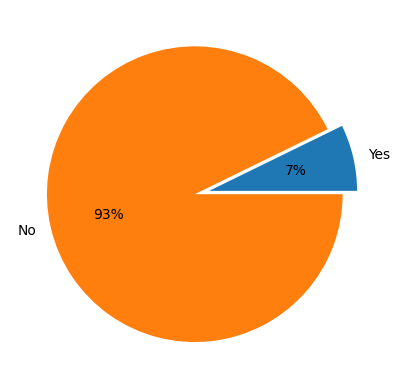

In [17]:
labelCounts = [len(df.loc[df['y']=='yes']),len(df.loc[df['y']=='no'])]
               
plt.pie(x=labelCounts, labels=["Yes", "No"], autopct='%.0f%%', explode=[0.1, 0])

The data set is highly imbalanced. Only 7% of the contacted customers actually ended up subscribing to a term deposit.


## Univariate Exploration
Let's explore each variable for it's characteristics

### 1. age

count    40000.000000
mean        40.544600
std          9.641776
min         19.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64


/home/nvaltekar/Desktop/ai-residency/term-deposit-marketing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nvaltekar/Desktop/ai-residency/term-deposit-marketing/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/nvaltekar/Desktop/ai-residency/term-deposit-marketing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nvaltekar/Desktop/ai-residency/term-deposit-marketing/lib/python3.11/site-pack

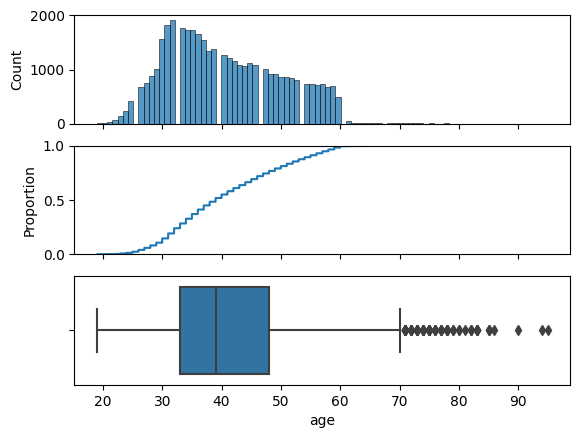

In [5]:
print(df.age.describe())

fig, axs = plt.subplots(3,1, sharex=True)
sns.histplot(x='age', data=df, ax=axs[0])
sns.ecdfplot(x='age', data=df, ax=axs[1])
sns.boxplot(x='age', data=df, ax=axs[2])
plt.show()

The average age of the contacted customers was 40.54 years. Over 50% of the contacted customers were less than 39 years old. The majority of the contacted customers were less than 60 years old. The customers contacted that were older than 70 years is quite rare and might be treated as outliers.

Now let's see the distribution of contacted customers by age that actually ended up subscribing to a term deposit vs. the ones who did not subscribe to a term deposit.

/home/nvaltekar/Desktop/ai-residency/term-deposit-marketing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nvaltekar/Desktop/ai-residency/term-deposit-marketing/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/nvaltekar/Desktop/ai-residency/term-deposit-marketing/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nvaltekar/Desktop/ai-residency/term-deposit-marketing/lib/python3.11/site-pack

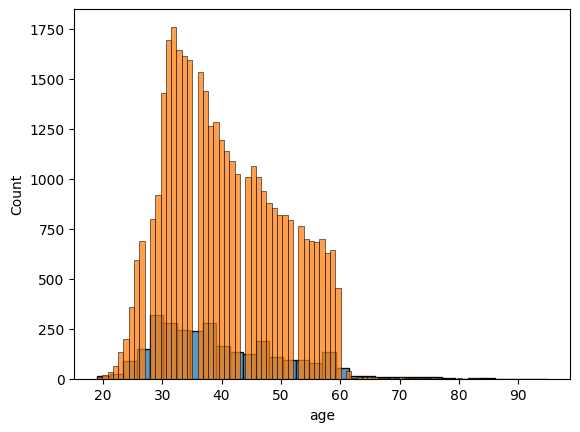

In [6]:
fig, axs = plt.subplots()
sns.histplot(df.loc[df['y']=='yes']['age'])
sns.histplot(df.loc[df['y']=='no']['age'])
plt.show()

In [21]:
pd.get_dummies(df)

,age,balance,day,duration,campaign,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,y_no,y_yes
0,58,2143,5,261,1,False,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
1,44,29,5,151,1,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
2,33,2,5,76,1,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,False
3,47,1506,5,92,1,False,True,False,False,False,...,False,False,False,False,False,True,False,False,True,False
4,33,1,5,198,1,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,395,3,107,1,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
39996,30,3340,3,238,3,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
39997,54,200,3,170,1,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
39998,34,1047,3,342,1,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False


In [7]:
# The data set does not contain any null values. Now proceed with further steps
# Check if the data set contains any duplicates

In [8]:
df.duplicated().sum()

0

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'balance'}>],
       [<Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'duration'}>],
       [<Axes: title={'center': 'campaign'}>, <Axes: >]], dtype=object)

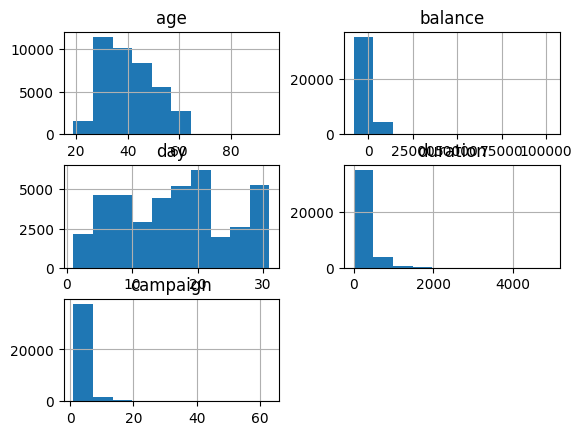

In [9]:
# The dataset contains 16 duplicate values. Drop duplicate values
df.drop_duplicates(inplace=True)
df.hist()

In [10]:
# Check if the data set is balanced
sns.countplot(x='Y', data=df)

ValueError: Could not interpret input 'Y'

In [ ]:
# This is a classification problem with single dependent variable "Y" and six independent variables
X = df.loc[:, df.columns!='Y']
y = df['Y']

# The dataset is very small. Allocating 10% data for testing and 90% data for training.
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=RANDOM_STATE, test_size=0.10)

In [ ]:
# List candidate classifiers without any parameter tuning. Create a dictionary that can be iterated over.

classifiers = [{'name': 'Naive Bayes',
                'classifier': GaussianNB()},
               {'name': 'Logistic Regression',
                'classifier': LogisticRegression(random_state=RANDOM_STATE)},
               {'name': 'K-Nearest Neighbours',
                'classifier': KNeighborsClassifier()},
               {'name': 'Decision Tree',
                'classifier': DecisionTreeClassifier(random_state=RANDOM_STATE)},
               {'name': 'Neural Net',
                'classifier': MLPClassifier(random_state=RANDOM_STATE, max_iter=10000)},
               {'name': 'Support Vector Machines',
                'classifier': SVC(random_state=RANDOM_STATE)},
               {'name': 'Random Forest',
                'classifier': RandomForestClassifier(random_state=RANDOM_STATE)},
               {'name': 'XGBoost',
                'classifier': GradientBoostingClassifier(random_state=RANDOM_STATE)}
              ]

In [ ]:
# Now iterate over each 
for classifier in classifiers:
    model = classifier['classifier'].fit(X_train, y_train)
    
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    print(f"***{classifier['name']}***")
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_test_pred),display_labels=model.classes_)
    disp.plot()
    plt.show()
    print(f"{classification_report(y_test, y_test_pred)}")

In [ ]:
# Random Forest and Support Vector Machine classifiers were able to achieve the required 73% accuracy without any parameter tuning (for RANDOM_STATE=3)

# Revisit the correlation heatmap
corrPlot = sns.heatmap(df.corr(), annot=True)

In [ ]:
# Note the correlation of of different variables
# The variable X2 and X4 are weakly correlated with the target variable and may not add much value to the model 
# Therefore, the questions corresponding to these two variables can possibly be removed from this survey. 
# X2 = Contents from my order were as I expected
# X4 = I paid a good price for my order